In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm  # Colormaps
from matplotlib.colors import LogNorm
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)

In [2]:
def __init__(self, ):
    super(Neural_Network, self).__init__()
# parameters
# TODO: parameters can be parameterized instead of declaringthem here
    self.inputSize = 2
    self.outputSize = 1
    self.hiddenSize = 3# weights
    self.W1 = torch.randn(self.inputSize, self.hiddenSize)
    self.W2 = torch.randn(self.hiddenSize, self.outputSize)

In [3]:
def forward(self, X):
    self.z = torch.matmul(X, self.W1)
    self.z2 = self.sigmoid(self.z) # activation function
    self.z3 = torch.matmul(self.z2, self.W2)
    o = self.sigmoid(self.z3) # final activation function
    return o

In [4]:
def backward(self, X, y, o):
    self.o_error = y - o # error in output
    self.o_delta = self.o_error * self.sigmoidPrime(o)
    self.z2_error = torch.matmul(self.o_delta, torch.t(self.W2))
    self.z2_delta = self.z2_error * self.sigmoidPrime(self.z2)
    self.W1 += torch.matmul(torch.t(X), self.z2_delta)
    self.W2 += torch.matmul(torch.t(self.z2), self.o_delta)

In [5]:
def update_state(xk, sk, wx, wRec):
    """
    Compute state k from the previous state (sk) and current
    input (xk), by use of the input weights (wx) and recursive
    weights (wRec).
    """
    return xk * wx + sk * wRec


def forward_states(X, wx, wRec):
    """
    Unfold the network and compute all state activations
    given the input X, input weights (wx), and recursive weights
    (wRec). Return the state activations in a matrix, the last
    column S[:,-1] contains the final activations.
    """
    # Initialise the matrix that holds all states for all
    #  input sequences. The initial state s0 is set to 0.
    S = np.zeros((X.shape[0], X.shape[1]+1))
    # Use the recurrence relation defined by update_state to update
    #  the states trough time.
    for k in range(0, X.shape[1]):
        # S[k] = S[k-1] * wRec + X[k] * wx
        S[:,k+1] = update_state(X[:,k], S[:,k], wx, wRec)
    return S


def loss(y, t):
    """MSE between the targets t and the outputs y."""
    return np.mean((t - y)**2)

In [6]:
def output_gradient(y, t):
    """
    Gradient of the MSE loss function with respect to the output y.
    """
    return 2. * (y - t)


def backward_gradient(X, S, grad_out, wRec):
    """
    Backpropagate the gradient computed at the output (grad_out)
    through the network. Accumulate the parameter gradients for
    wX and wRec by for each layer by addition. Return the parameter
    gradients as a tuple, and the gradients at the output of each layer.
    """
    # Initialise the array that stores the gradients of the loss with
    #  respect to the states.
    grad_over_time = np.zeros((X.shape[0], X.shape[1]+1))
    grad_over_time[:,-1] = grad_out
    # Set the gradient accumulations to 0
    wx_grad = 0
    wRec_grad = 0
    for k in range(X.shape[1], 0, -1):
        # Compute the parameter gradients and accumulate the results.
        wx_grad += np.sum(
            np.mean(grad_over_time[:,k] * X[:,k-1], axis=0))
        wRec_grad += np.sum(
            np.mean(grad_over_time[:,k] * S[:,k-1]), axis=0)
        # Compute the gradient at the output of the previous layer
        grad_over_time[:,k-1] = grad_over_time[:,k] * wRec
    return (wx_grad, wRec_grad), grad_over_time

In [7]:
# Define Rprop optimisation function
def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    """
    Update RProp values in one iteration.
    Args:
        X: input data.
        t: targets.
        W: Current weight parameters.
        W_prev_sign: Previous sign of the W gradient.
        W_delta: RProp update values (Delta).
        eta_p, eta_n: RProp hyperparameters.
    Returns:
        (W_delta, W_sign): Weight update and sign of last weight
                           gradient.
    """
    # Perform forward and backward pass to get the gradients
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:,-1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    W_sign = np.sign(W_grads)  # Sign of new gradient
    # Update the Delta (update value) for each weight
    #  parameter seperately
    for i, _ in enumerate(W):
        if W_sign[i] == W_prev_sign[i]:
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n
    return W_delta, W_sign

In [8]:
nb_of_samples = 20
sequence_len = 10
# Create the sequences
X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
# Create the targets for each sequence
t = np.sum(X, axis=1)
###


In [9]:
# Set the weight parameters used during gradient checking
params = [1.2, 1.2]  # [wx, wRec]
# Set the small change to compute the numerical gradient
eps = 1e-7
# Compute the backprop gradients
S = forward_states(X, params[0], params[1])
grad_out = output_gradient(S[:,-1], t)
backprop_grads, grad_over_time = backward_gradient(
    X, S, grad_out, params[1])
# Compute the numerical gradient for each parameter in the layer
for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    params[p_idx] += eps
    plus_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    # - eps
    params[p_idx] -= 2 * eps
    min_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    # reset param value
    params[p_idx] += eps
    # calculate numerical gradient
    grad_num = (plus_loss - min_loss) / (2*eps)
    # Raise error if the numerical grade is not close to
    #  the backprop gradient
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError((
            f'Numerical gradient of {grad_num:.6f} is not close to '
            f'the backpropagation gradient of {grad_backprop:.6f}!'))
print('No gradient errors found')

No gradient errors found


In [10]:
# Define points to annotate (wx, wRec, color)
points = [(2,1,'r'), (1,2,'b'), (1,-2,'m'), (1,0,'c'),
          (1,0.5,'g'), (1,-0.5,'y')]


def get_loss_surface(w1_low, w1_high, w2_low, w2_high,
                     nb_of_ws, loss_func):
    """Plot the loss surface."""
    # Vector of weights for which we want to plot the loss.
    w1 = np.linspace(w1_low, w1_high, num=nb_of_ws)  # Weight 1
    w2 = np.linspace(w2_low, w2_high, num=nb_of_ws)  # Weight 2
    ws1, ws2 = np.meshgrid(w1, w2)  # Generate grid
    loss_ws = np.zeros((nb_of_ws, nb_of_ws))  # Initialize loss matrix
    # Fill the loss matrix for each combination of weights
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            loss_ws[i,j] = loss_func(ws1[i,j], ws2[i,j])
    return ws1, ws2, loss_ws


def plot_surface(ax, ws1, ws2, loss_ws):
    """Plot the loss in function of the weights."""
    surf = ax.contourf(
        ws1, ws2, loss_ws, levels=np.logspace(-0.2, 8, 30),
        cmap=cm.viridis, norm=LogNorm())
    ax.set_xlabel('$w_{in}$', fontsize=12)
    ax.set_ylabel('$w_{rec}$', fontsize=12)
    return surf


def plot_points(ax, points):
    """Plot the annotation points on the given axis."""
    for wx, wRec, c in points:
        ax.plot(wx, wRec, c+'o', linewidth=2)


def get_loss_surface_figure(loss_func, points):
    """Plot the loss surfaces together with the annotated points."""
    # Plot figures
    fig = plt.figure(figsize=(10, 4))
    # Plot overview of loss function
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(
        -3, 3, -3, 3, 50, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1 + 1)
    plot_points(ax_1, points)
    ax_1.set_xlim(-3, 3)
    ax_1.set_ylim(-3, 3)
    # Plot zoom of loss function
    ax_2 = fig.add_subplot(1,2,2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(
        -0.1, 2.1, -0.1, 2.1, 50, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2 + 1)
    plot_points(ax_2, points)
    ax_2.set_xlim(-0.1, 2.1)
    ax_2.set_ylim(-0.1, 2.1)
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(
        surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel(
        '$\\xi$', fontsize=12, rotation=0, labelpad=20)
    cbar.set_ticklabels(
        ['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    fig.suptitle('Loss surface', fontsize=15)
    return fig


def plot_gradient_over_time(points, get_grad_over_time):
    """Plot the gradients of the annotated points and how
    they evolve over time."""
    fig = plt.figure(figsize=(7, 3))
    ax = plt.subplot(111)
    # Plot points
    for wx, wRec, c in points:
        grad_over_time = get_grad_over_time(wx, wRec)
        x = np.arange(-grad_over_time.shape[1]+1, 1, 1)
        plt.plot(
            x, np.sum(grad_over_time, axis=0), c+'-',
            label=f'({wx}, {wRec})', linewidth=1, markersize=8)
    plt.xlim(0, -grad_over_time.shape[1]+1)
    # Set up plot axis
    plt.xticks(x)
    plt.yscale('symlog')
    plt.yticks([10**8, 10**6, 10**4, 10**2, 0, -10**2, -10**4,
                -10**6, -10**8])
    plt.xlabel('timestep k', fontsize=12)
    plt.ylabel('$\\frac{\\partial \\xi}{\\partial S_{k}}$',
               fontsize=20, rotation=0)
    plt.title(('Unstability of gradient in backward propagation.'
               '\n(backpropagate from left to right)'))
    # Set legend
    leg = plt.legend(
        loc='center left', bbox_to_anchor=(1, 0.5),
        frameon=False, numpoints=1)
    leg.set_title('$(w_x, w_{rec})$', prop={'size':15})
    fig.subplots_adjust(right=0.8)


def get_grad_over_time(wx, wRec):
    """Helper func to only get the gradient over time
    from wx and wRec."""
    S = forward_states(X, wx, wRec)
    grad_out = output_gradient(S[:,-1], t).sum()
    _, grad_over_time = backward_gradient(X, S, grad_out, wRec)
    return grad_over_time

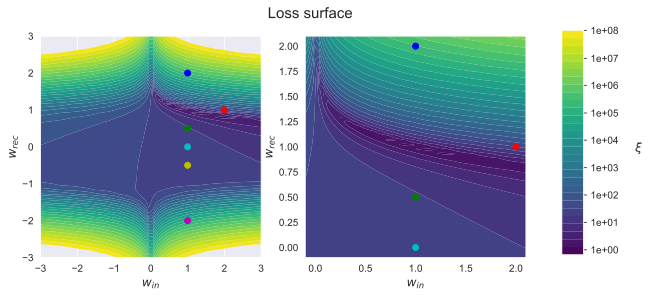

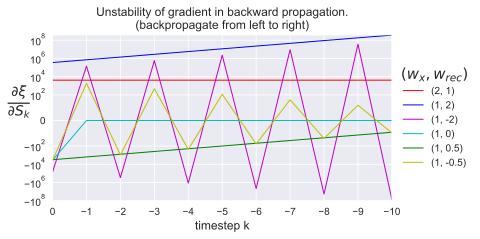

In [11]:
# Plot loss surface and gradients

# Get and plot the loss surface figure with markers
fig = get_loss_surface_figure(
    lambda w1, w2: loss(forward_states(X, w1, w2)[:,-1] , t), points)

# Get the plots of the gradients changing by backpropagating.
plot_gradient_over_time(points, get_grad_over_time)
# Show figures
plt.show()

In [12]:

# Define plot function
def plot_optimisation(ls_of_ws, loss_func):
    """Plot the optimisation iterations on the loss surface."""
    ws1, ws2 = zip(*ls_of_ws)
    # Plot figures
    fig = plt.figure(figsize=(10, 4))
    # Plot overview of loss function
    ax_1 = fig.add_subplot(1, 2, 1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(
        -3, 3, -3, 3, 50, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1 + 1)
    ax_1.plot(ws1, ws2, 'wo', markersize=3)
    ax_1.scatter(ws1[-1], ws2[-1], color='w', marker='*', s=150, edgecolors='k')
    ax_1.set_xlim([-3, 3])
    ax_1.set_ylim([-3, 3])
    # Plot zoom of loss function
    ax_2 = fig.add_subplot(1, 2, 2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(
        0, 2, 0, 2, 50, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2 + 1)
    ax_2.set_xlim([0, 2])
    ax_2.set_ylim([0, 2])
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2)
    ax_2.plot(ws1, ws2, 'wo',
              label='RProp iterations', markersize=3)
    ax_2.scatter(ws1[-1], ws2[-1], color='w', marker='*', s=150, edgecolors='k')
    ax_2.legend()
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(
        surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel(
        '$\\xi$', fontsize=12, rotation=0, labelpad=20)
    cbar.set_ticklabels(
        ['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    plt.suptitle('Loss surface', fontsize=12)
    plt.show()

# Plot the optimisation
plot_optimisation(
    ls_of_ws, lambda w1, w2: loss(forward_states(X, w1, w2)[:,-1] , t))
plt.show()

NameError: name 'ls_of_ws' is not defined

In [ ]:
# Perform Rprop optimisation

# Set hyperparameters
eta_p = 1.2
eta_n = 0.5

# Set initial parameters
W = [-1.5, 2]  # [wx, wRec]
W_delta = [0.001, 0.001]  # Update values (Delta) for W
W_sign = [0, 0]  # Previous sign of W

ls_of_ws = [(W[0], W[1])]  # List of weights to plot
# Iterate over 500 iterations
for i in range(500):
    # Get the update values and sign of the last gradient
    W_delta, W_sign = update_rprop(
        X, t, W, W_sign, W_delta, eta_p, eta_n)
    # Update each weight parameter seperately
    for i, _ in enumerate(W):
        W[i] -= W_sign[i] * W_delta[i]
    ls_of_ws.append((W[0], W[1]))  # Add weights to list to plot

print(f'Final weights are: wx = {W[0]:.4f},  wRec = {W[1]:.4f}')

In [ ]:
test_inpt = np.asmatrix([[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]])
test_outpt = forward_states(test_inpt, W[0], W[1])[:,-1]
sum_test_inpt = test_inpt.sum()
print((
    f'Target output: {sum_test_inpt:d} vs Model output: '
    f'{test_outpt[0]:.2f}'))
